__Author:__ Bram Van de Sande

__Date:__ 29 APR 2019

__Outline:__ Notebook demonstrating SCENIC integration with scanpy.

In [2]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
from cytoolz import compose
import operator as op

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell

/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/miniconda/lib/python3.9/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.21.5 (/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/miniconda/lib/python3.9/site-packages), Requirement.parse('numpy<1.28.0,>=1.21.6'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/miniconda/lib/python3.9/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/miniconda/lib/python3.9/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future versio

In [3]:
# Set maximum number of jobs
sc.settings.njobs = 30
sc.settings.set_figure_params(dpi=100,dpi_save=300,frameon=False,facecolor='white',fontsize=16,vector_friendly=True,figsize=(5,5))


In [4]:
sample = 'all'
resolution = 'pheno_leiden'
celltype = 'Fibroblast_Cell'

In [5]:
wdir = f"/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/5.8_scRNA_CAF_TF/CXCL12"
os.system(f'mkdir -p {wdir}')
os.chdir(wdir)

In [8]:
f_anndata_path = f"/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/10.2_CAF_subtype_public_reflect/Fibroblast_integrate.h5ad"

In [6]:
BASE_FOLDER = wdir

EXP_MTX_QC_TPM_FNAME = os.path.join(BASE_FOLDER, 'qc.tpm.csv')
METADATA_FNAME = os.path.join(BASE_FOLDER, 'metadata.csv')
ANNDATA_FNAME = os.path.join(BASE_FOLDER, 'anndata.h5ad')
AUCELL_MTX_FNAME = os.path.join(BASE_FOLDER, 'auc.csv')
REGULONS_DAT_FNAME = os.path.join(BASE_FOLDER, 'regulons.dat')
LOOM_FNAME = os.path.join(BASE_FOLDER, 'anndata.loom')

__ANNDATA__

In [9]:
adata = sc.read(f_anndata_path)


In [53]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,group,percent.mt,pANN_0.25_0.005_201,doublet_info,RNA_snn_res.0.4,seurat_clusters,RNA_snn_res.0.5,...,Chen_ExhaustT,Chen_NaiveT,Chen_EffectorT,Chen_RegT,MS,_scvi_batch,_scvi_labels,pheno_leiden,CellSubType2,CellSubType3
R492_CELL1093_N1-0,tumor,6435.0,2408,R492,5.461558,0.277778,Singlet,7,12,7,...,NaN,NaN,NaN,NaN,NaN,3,0,14,Fibro_F2RL2,NaN
R492_CELL81_N4-0,tumor,21677.0,4774,R492,4.450577,0.277778,Singlet,3,2,6,...,NaN,NaN,NaN,NaN,NaN,3,0,4,Fibro_COL11A1,NaN
R492_CELL11_N2-0,tumor,6897.0,2390,R492,7.110796,0.222222,Singlet,5,5,3,...,NaN,NaN,NaN,NaN,NaN,3,0,2,Stellate_MYH11,NaN
R492_CELL1188_N1-0,tumor,4493.0,1802,R492,0.603490,0.277778,Singlet,8,14,8,...,NaN,NaN,NaN,NaN,NaN,3,0,19,Fibro_MME,NaN
R492_CELL1402_N1-0,tumor,3246.0,1473,R492,0.241313,0.222222,Singlet,8,14,8,...,NaN,NaN,NaN,NaN,NaN,3,0,19,Fibro_MME,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTAGTTCTCAACACTG-1_3_2-1,HPD3,12631.0,3767,NaN,3.353046,NaN,NaN,NaN,0,NaN,...,0.083310,0.0,0.0,0.145792,Normal,2,0,13,NaN,qPSC
TTCCCAGCACGCGAAA-1_3_2-1,HPD3,12048.0,3595,NaN,1.700244,NaN,NaN,NaN,0,NaN,...,0.209038,0.0,0.0,0.151081,Normal,2,0,13,NaN,qPSC
TTCTACAGTCAACATC-1_3_2-1,HPD3,6614.0,2371,NaN,8.293027,NaN,NaN,NaN,5,NaN,...,0.000000,0.0,0.0,0.000000,Normal,2,0,13,NaN,iCAF
TTGGAACGTGCAACTT-1_3_2-1,HPD3,28499.0,4993,NaN,1.461039,NaN,NaN,NaN,7,NaN,...,0.102734,0.0,0.0,0.000000,Normal,2,0,3,NaN,IL11.CAF


To infer GRNs (with SCENIC) the QC'd expression matrix is saved as csv.

In [54]:
# sc.pp.normalize_total(adata, inplace=True, exclude_highly_expressed=True)
# sc.pp.log1p(adata)
adata.to_df().to_csv(EXP_MTX_QC_TPM_FNAME)

KeyboardInterrupt: 

__SCENIC: RUN GRN INFERENCE (GRNBOOST2)__

```
pyscenic grn qc.tpm.csv tfs.txt -o adjacencies.tsv --num_workers 4
```

List of TFs (i.e. `tfs.txt`) is downloaded from: Samuel A Lambert, et al. The Human Transcription Factors. Cell 2018 https://dx.doi.org/10.1016/j.cell.2018.01.029

__SCENIC: RUN REGULON PREDICTION (CISTARGET)__

```
pyscenic ctx adjacencies.tsv hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings.feather hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings.feather --annotations_fname motifs-v9-nr.hgnc-m0.001-o0.0.tbl --expression_mtx_fname qc.tpm.csv --output motifs.csv --num_workers 26
```

__SCENIC: RUN CELLULAR ENRICHMENT (AUCELL)__

In [10]:
f_tfs = "/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/script/spatial_pipeline/bin/SCENIC/resources/hs_hgnc_curated_tfs.txt"  # human

In [ ]:
!pyscenic grn {EXP_MTX_QC_TPM_FNAME} {f_tfs} -o adj.tsv --num_workers 20 > scenic_grn.log

智人 - hg38 - refseq_r80 - SCENIC+ 数据库 - 基于基因
选择主题数据库：
scores：矩阵包含作为行的图案和作为列的基因以及作为值的集群克星CRM分数。与 DEM 一起使用。
rankings：矩阵包含作为行的基序和作为列的基因以及每个基因和基序的排名位置（基于 CRM 分数）作为值。与 cisTarget (R) 一起使用。
数据库名称中指示了在其中对基序进行评分的基因的 TSS 周围的搜索空间：
500bpUp：TSS 上游 500bp。
TSS+/-10kb：TSS 周围 10kb（总计：20kb）。
TSS+/-5kb：TSS 周围 5kb（总计：10kb）。
5kbUp,FullTx：5kb 上游 TSS 和转录本内含子。
500bpUp100Dw：TSS 上游 500bp，下游 100bp。
使用 zsync_curl 下载数据库
指定数据库：
feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather'
feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather'
# 使用 zsync_curl 下载数据库：
"\${ZSYNC_CURL}" "\${feather_database_url}.zsync"
或者，您可以直接下载数据库：
# 指定数据库：
feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather'
feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
feather_database_url='https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather'
feather_database="\${feather_database_url##*/}"

# 直接下载数据库（使用 wget 或 curl）：
wget "\${feather_database_url}"
curl -O "\${feather_database_url}"

# 下载 sha256sum.txt（使用 wget 或 curl）：
wget https://resources.aertslab.org/cistarget/databases/sha256sum.txt
curl -O https://resources.aertslab.org/cistarget/databases/sha256sum.txt

# 检查 sha256 校验和是否与下载的数据库匹配：
awk -v feather_database=\${feather_database} '$2 == feather_database' sha256sum.txt | sha256sum -c -

# 如果你下载了多个数据库，你可以一次检查它们：
sha256sum -c sha256sum.txt

In [56]:
import glob
# ranking databases
f_db_glob = "/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/script/spatial_pipeline/bin/SCENIC/resources/*ranking*feather"
# f_db_glob = "/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/script/spatial_pipeline/bin/SCENIC/resources/*feather"
f_db_names = ' '.join(glob.glob(f_db_glob))

# motif databases
f_motif_path = "/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/script/spatial_pipeline/bin/SCENIC/resources/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [57]:
f_db_names

'/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/script/spatial_pipeline/bin/SCENIC/resources/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather /jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/script/spatial_pipeline/bin/SCENIC/resources/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'

In [ ]:
!pyscenic ctx adj.tsv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {EXP_MTX_QC_TPM_FNAME} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20 > scenic_ctx.log

In [58]:
def derive_regulons(motiffl, folder):
    # Load enriched motifs.
    motifs = load_motifs(motiffl)
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings', 
                                 'hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings'),
                                  motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    # regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
    #                                                                   & ((motifs['Annotation'] == 'gene is directly annotated')
    #                                                                     | (motifs['Annotation'].str.startswith('gene is orthologous to')
    #                                                                        & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
    #                                                                  ])))
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0)])))
    
    # Rename regulons, i.e. remove suffix.
    regulons = list(map(lambda r: r.rename(r.transcription_factor), regulons))

    # Pickle these regulons.
    with open(os.path.join(folder, 'regulons.dat'), 'wb') as f:
        pickle.dump(regulons, f)

In [59]:
derive_regulons('reg.csv', BASE_FOLDER)

/tmp/ipykernel_58907/797521496.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
/tmp/ipykernel_58907/797521496.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  motifs.Context), dtype=np.bool) & \
/tmp/ipykernel_58907/797521496.py:19: DeprecationW

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [17]:
with open(REGULONS_DAT_FNAME, 'rb') as f:
    regulons = pickle.load(f)

In [12]:
exp_mtx = pd.DataFrame(adata.X.toarray(),index=adata.obs_names,columns=adata.var_names)

In [62]:
auc_mtx = aucell(exp_mtx, regulons, num_workers=20)

In [63]:
auc_mtx.to_csv(AUCELL_MTX_FNAME)

__ADD DIMENSIONAL REDUCTIONS__

In [64]:
add_scenic_metadata(adata, auc_mtx, regulons)

AnnData object with n_obs × n_vars = 27063 × 25679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'group', 'percent.mt', 'pANN_0.25_0.005_201', 'doublet_info', 'RNA_snn_res.0.4', 'seurat_clusters', 'RNA_snn_res.0.5', 'RNA_snn_res.0.8', 'RNA_snn_res.1.2', 'RNA_snn_res.1', 'celltype', 'pANN_0.25_0.18_1130', 'pANN_0.25_0.005_152', 'pANN_0.25_0.01_119', 'pANN_0.25_0.03_36', 'pANN_0.25_0.02_66', 'pANN_0.25_0.005_402', 'pANN_0.25_0.001_1065', 'pANN_0.25_0.005_193', 'pANN_0.25_0.001_1420', 'pANN_0.25_0.005_713', 'pANN_0.25_0.03_123', 'pANN_0.25_0.05_760', 'pANN_0.25_0.005_420', 'pANN_0.25_0.27_608', 'pANN_0.25_0.04_76', 'pANN_0.25_0.001_977', 'pANN_0.25_0.005_285', 'pANN_0.25_0.01_124', 'pANN_0.25_0.01_135', 'pANN_0.25_0.02_41', 'pANN_0.25_0.005_255', 'pANN_0.25_0.05_548', 'pANN_0.25_0.005_534', 'pANN_0.25_0.005_513', 'Patients', 'cellTypes', 'sample', 'tissue', 'cellTypes_new', 'cellTypes_filt', 'sampleType', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.9', 'RNA_snn_res.1.1', '

In [65]:
adata.write_h5ad(ANNDATA_FNAME)

In [66]:
aucell_adata = sc.AnnData(X=auc_mtx.sort_index())
aucell_adata.obs = adata.obs
aucell_adata

AnnData object with n_obs × n_vars = 27063 × 148
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'group', 'percent.mt', 'pANN_0.25_0.005_201', 'doublet_info', 'RNA_snn_res.0.4', 'seurat_clusters', 'RNA_snn_res.0.5', 'RNA_snn_res.0.8', 'RNA_snn_res.1.2', 'RNA_snn_res.1', 'celltype', 'pANN_0.25_0.18_1130', 'pANN_0.25_0.005_152', 'pANN_0.25_0.01_119', 'pANN_0.25_0.03_36', 'pANN_0.25_0.02_66', 'pANN_0.25_0.005_402', 'pANN_0.25_0.001_1065', 'pANN_0.25_0.005_193', 'pANN_0.25_0.001_1420', 'pANN_0.25_0.005_713', 'pANN_0.25_0.03_123', 'pANN_0.25_0.05_760', 'pANN_0.25_0.005_420', 'pANN_0.25_0.27_608', 'pANN_0.25_0.04_76', 'pANN_0.25_0.001_977', 'pANN_0.25_0.005_285', 'pANN_0.25_0.01_124', 'pANN_0.25_0.01_135', 'pANN_0.25_0.02_41', 'pANN_0.25_0.005_255', 'pANN_0.25_0.05_548', 'pANN_0.25_0.005_534', 'pANN_0.25_0.005_513', 'Patients', 'cellTypes', 'sample', 'tissue', 'cellTypes_new', 'cellTypes_filt', 'sampleType', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.9', 'RNA_snn_res.1.1', 'RN

In [67]:
sc.pp.highly_variable_genes(aucell_adata,n_top_genes=20)

In [68]:
hvgs = aucell_adata.var_names[aucell_adata.var['highly_variable']].tolist()

/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/scanpy/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/scanpy/scanpy/plotting/_utils.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
meta NOT subset; don't know how to subset; dropped
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/miniconda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


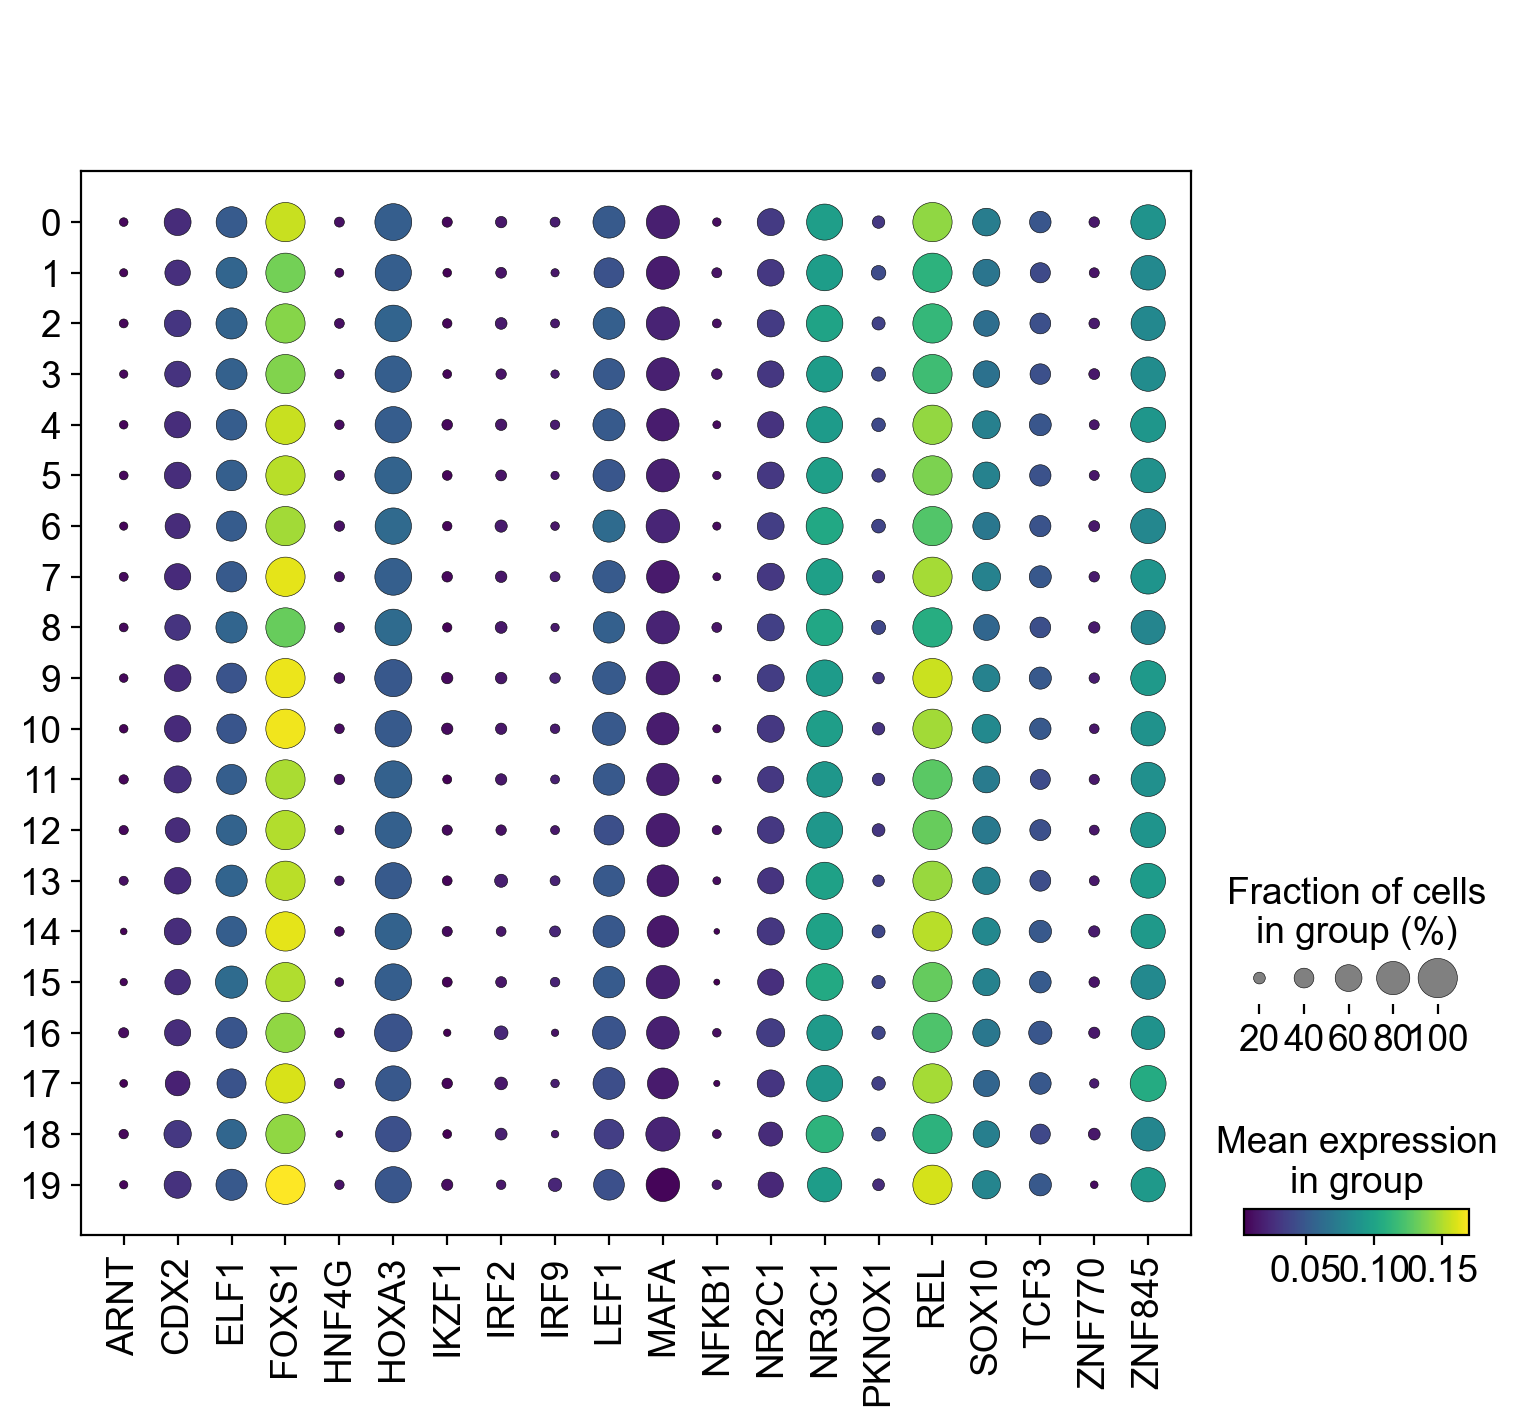

In [69]:
sc.pl.dotplot(aucell_adata, hvgs, groupby=resolution,cmap='viridis',save='highly_variable_TFs_region.pdf')

In [70]:
aucell_adata.write('aucell_adata.h5ad')

In [71]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [72]:
rss_cellType = regulon_specificity_scores(auc_mtx, adata.obs[resolution])

In [73]:
rss_cellType.T.to_csv('TF_regulon_specificity_scores.csv')

In [78]:
adata.obs[resolution] = adata.obs[resolution].astype('str').astype('category')

In [86]:
rss_cellType.index = rss_cellType.index.astype('str')

In [90]:
rss_cellType.T.columns

Index(['14', '4', '2', '19', '5', '6', '13', '1', '0', '3', '11', '10', '12',
       '7', '9', '8', '17', '16', '15', '18'],
      dtype='object')

meta NOT subset; don't know how to subset; dropped


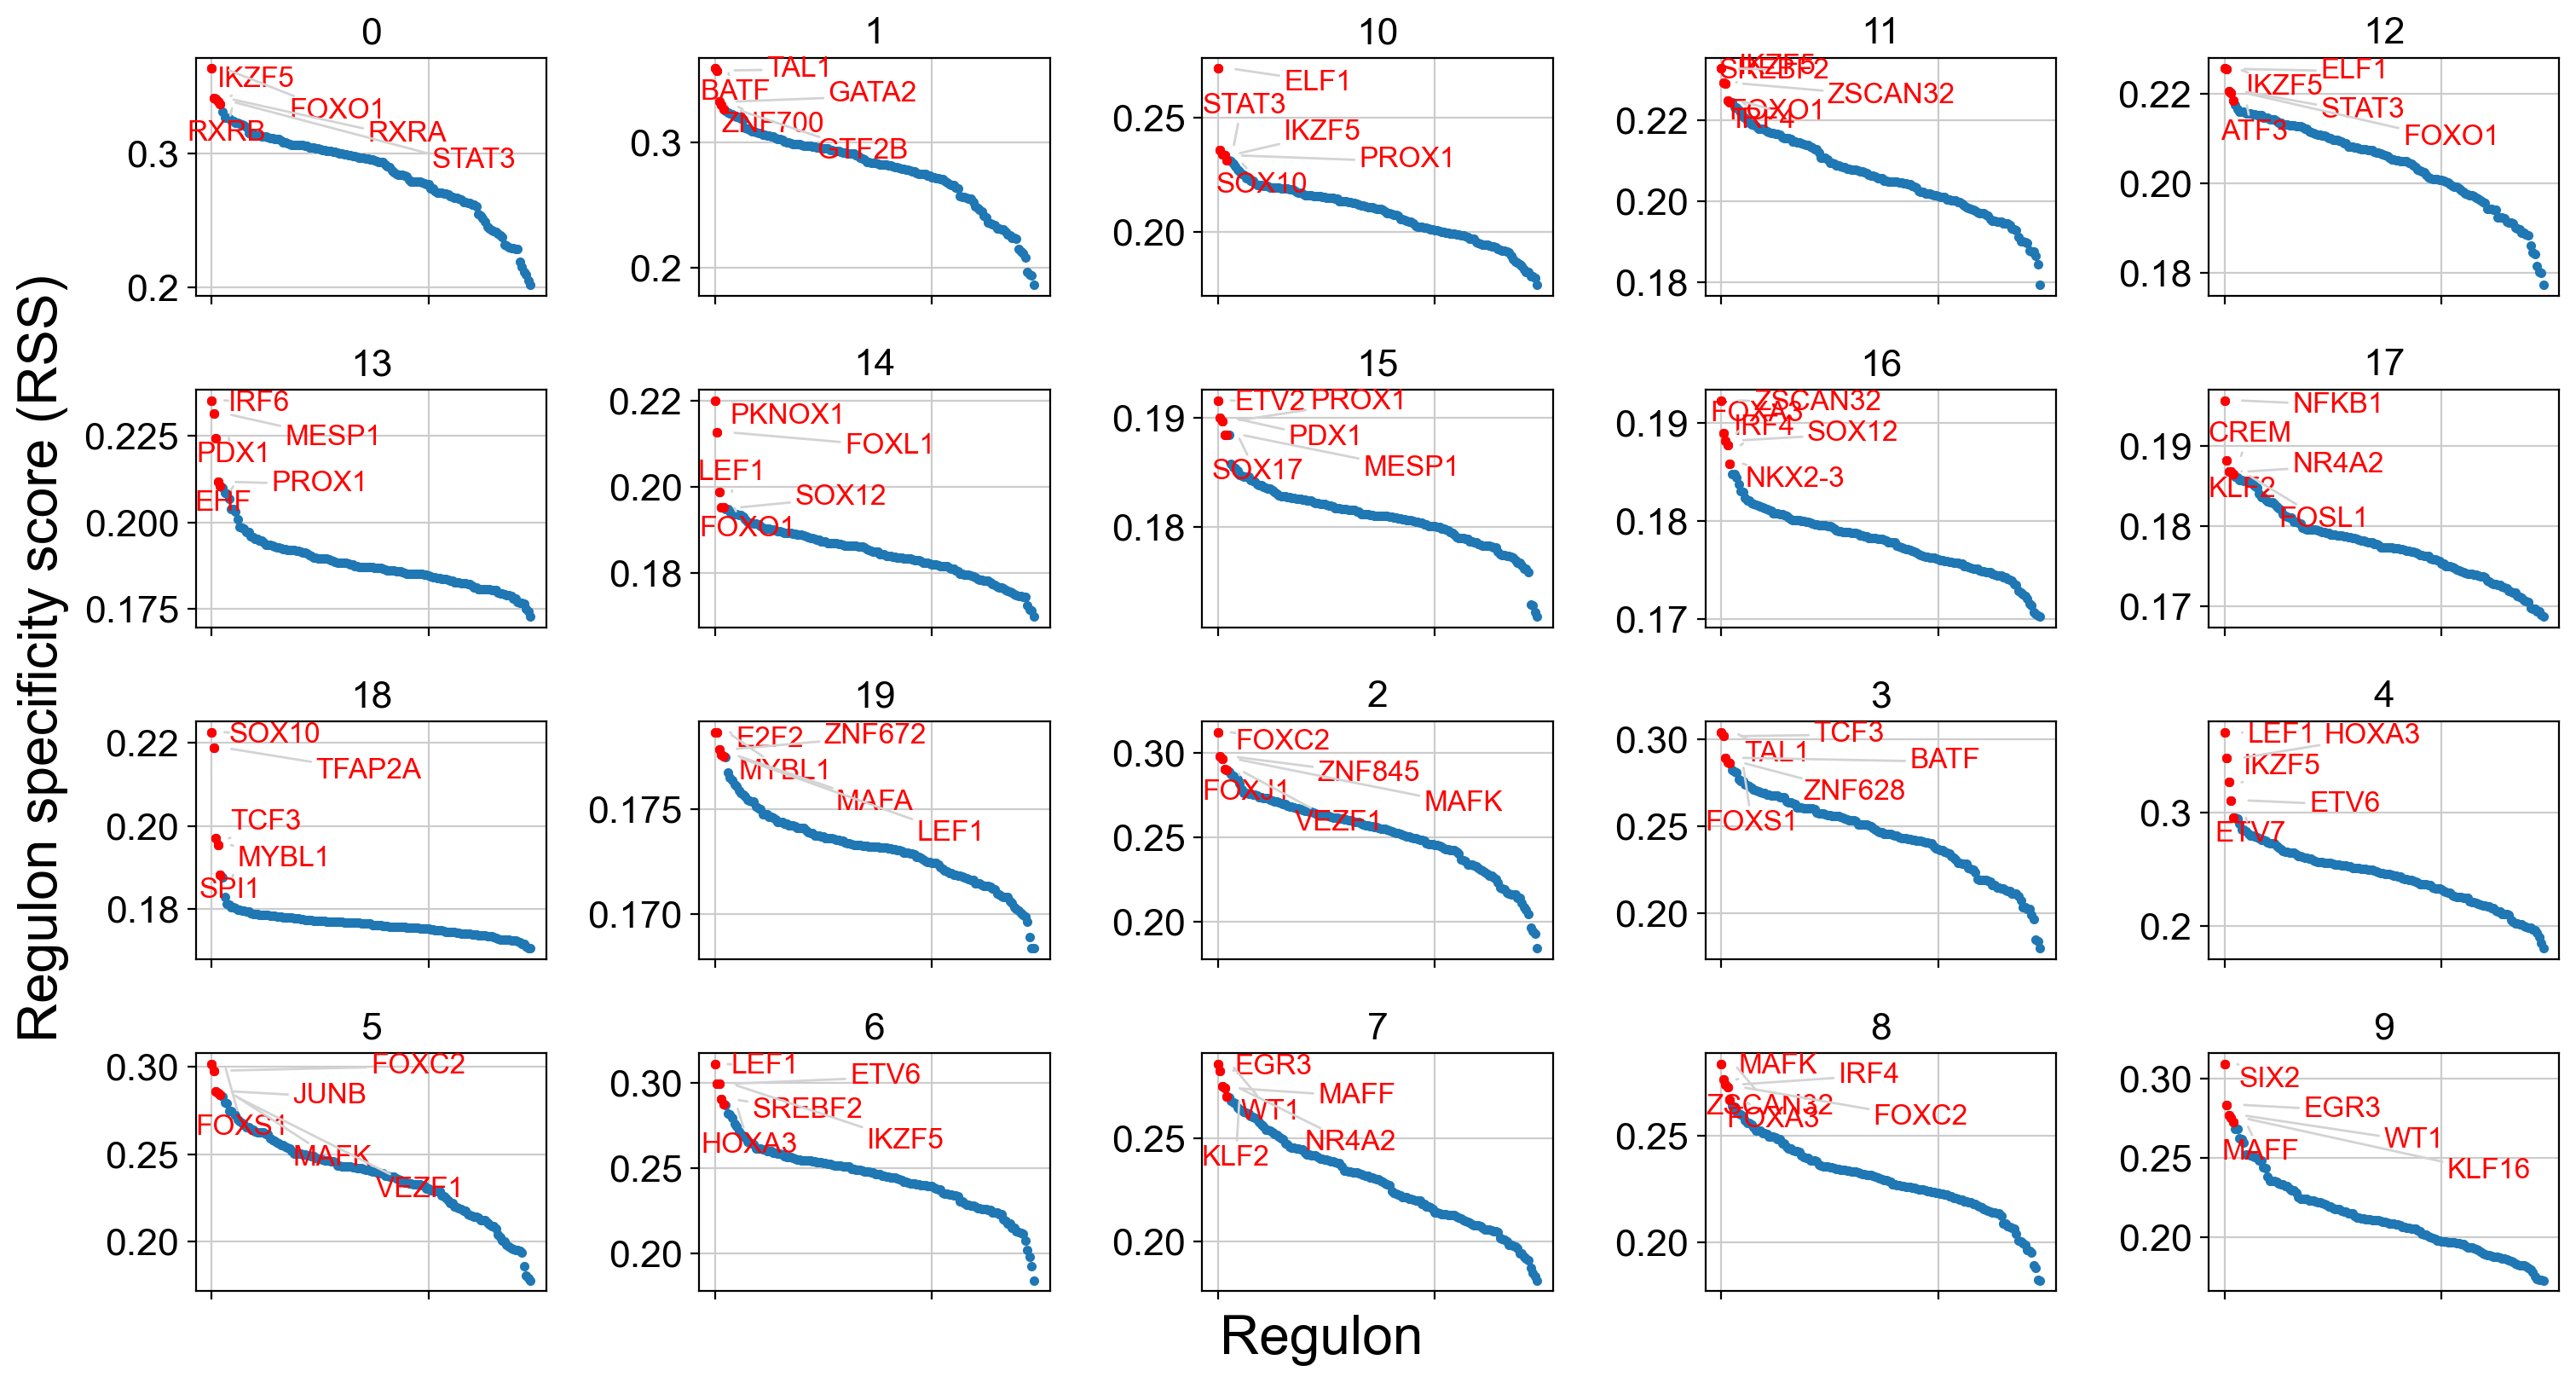

In [91]:
cats = sorted(list(set(adata.obs[resolution])))

fig = plt.figure(figsize=(15, 8))
for c, num in zip(cats, range(1, len(cats) + 1)):
    x = rss_cellType.T[c]
    ax = fig.add_subplot(4, 5, num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim(x.min() - (x.max() - x.min()) * 0.05,
                x.max() + (x.max() - x.min()) * 0.05)
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts,
                autoalign='xy',
                ha='right',
                va='bottom',
                arrowprops=dict(arrowstyle='-', color='lightgrey'),
                precision=0.001)

fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00,
         0.5,
         'Regulon specificity score (RSS)',
         ha='center',
         va='center',
         rotation='vertical',
         size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
    'figure.titlesize': 'large',
    'axes.labelsize': 'medium',
    'axes.titlesize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium'
})
plt.savefig("cellType-RSS-top5.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [92]:
topreg = []
for i, c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index))
# topreg = list(set(topreg))

In [93]:
seen = set()
topreg_unique = []
for item in topreg:
    if item not in seen:
        seen.add(item)
        topreg_unique.append(item)

In [94]:
topreg_dict = {}
for i, c in enumerate(cats):
    topreg_dict[c] = list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)

In [95]:
auc_mtx_Z = pd.DataFrame(index=auc_mtx.index)
for col in list(auc_mtx.columns):
    auc_mtx_Z[col] = (auc_mtx[col] -
                      auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)

/tmp/ipykernel_58907/1230290344.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[col] = (auc_mtx[col] -
/tmp/ipykernel_58907/1230290344.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[col] = (auc_mtx[col] -
/tmp/ipykernel_58907/1230290344.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

In [97]:
import os, sys

sys.path.insert(
    0,
    '/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/yixianai/SC_reanalysis/script'
)
from utils import getDefaultColors, removeBiasGenes
# colors = sns.color_palette('bright',n_colors=len(cats) )
colors = getDefaultColors(len(cats), type=1)
colorsd = dict(zip(cats, colors))
colormap = [colorsd[x] for x in adata.obs[resolution]]

/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/scanpy/scanpy/plotting/_utils.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
meta NOT subset; don't know how to subset; dropped
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/miniconda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


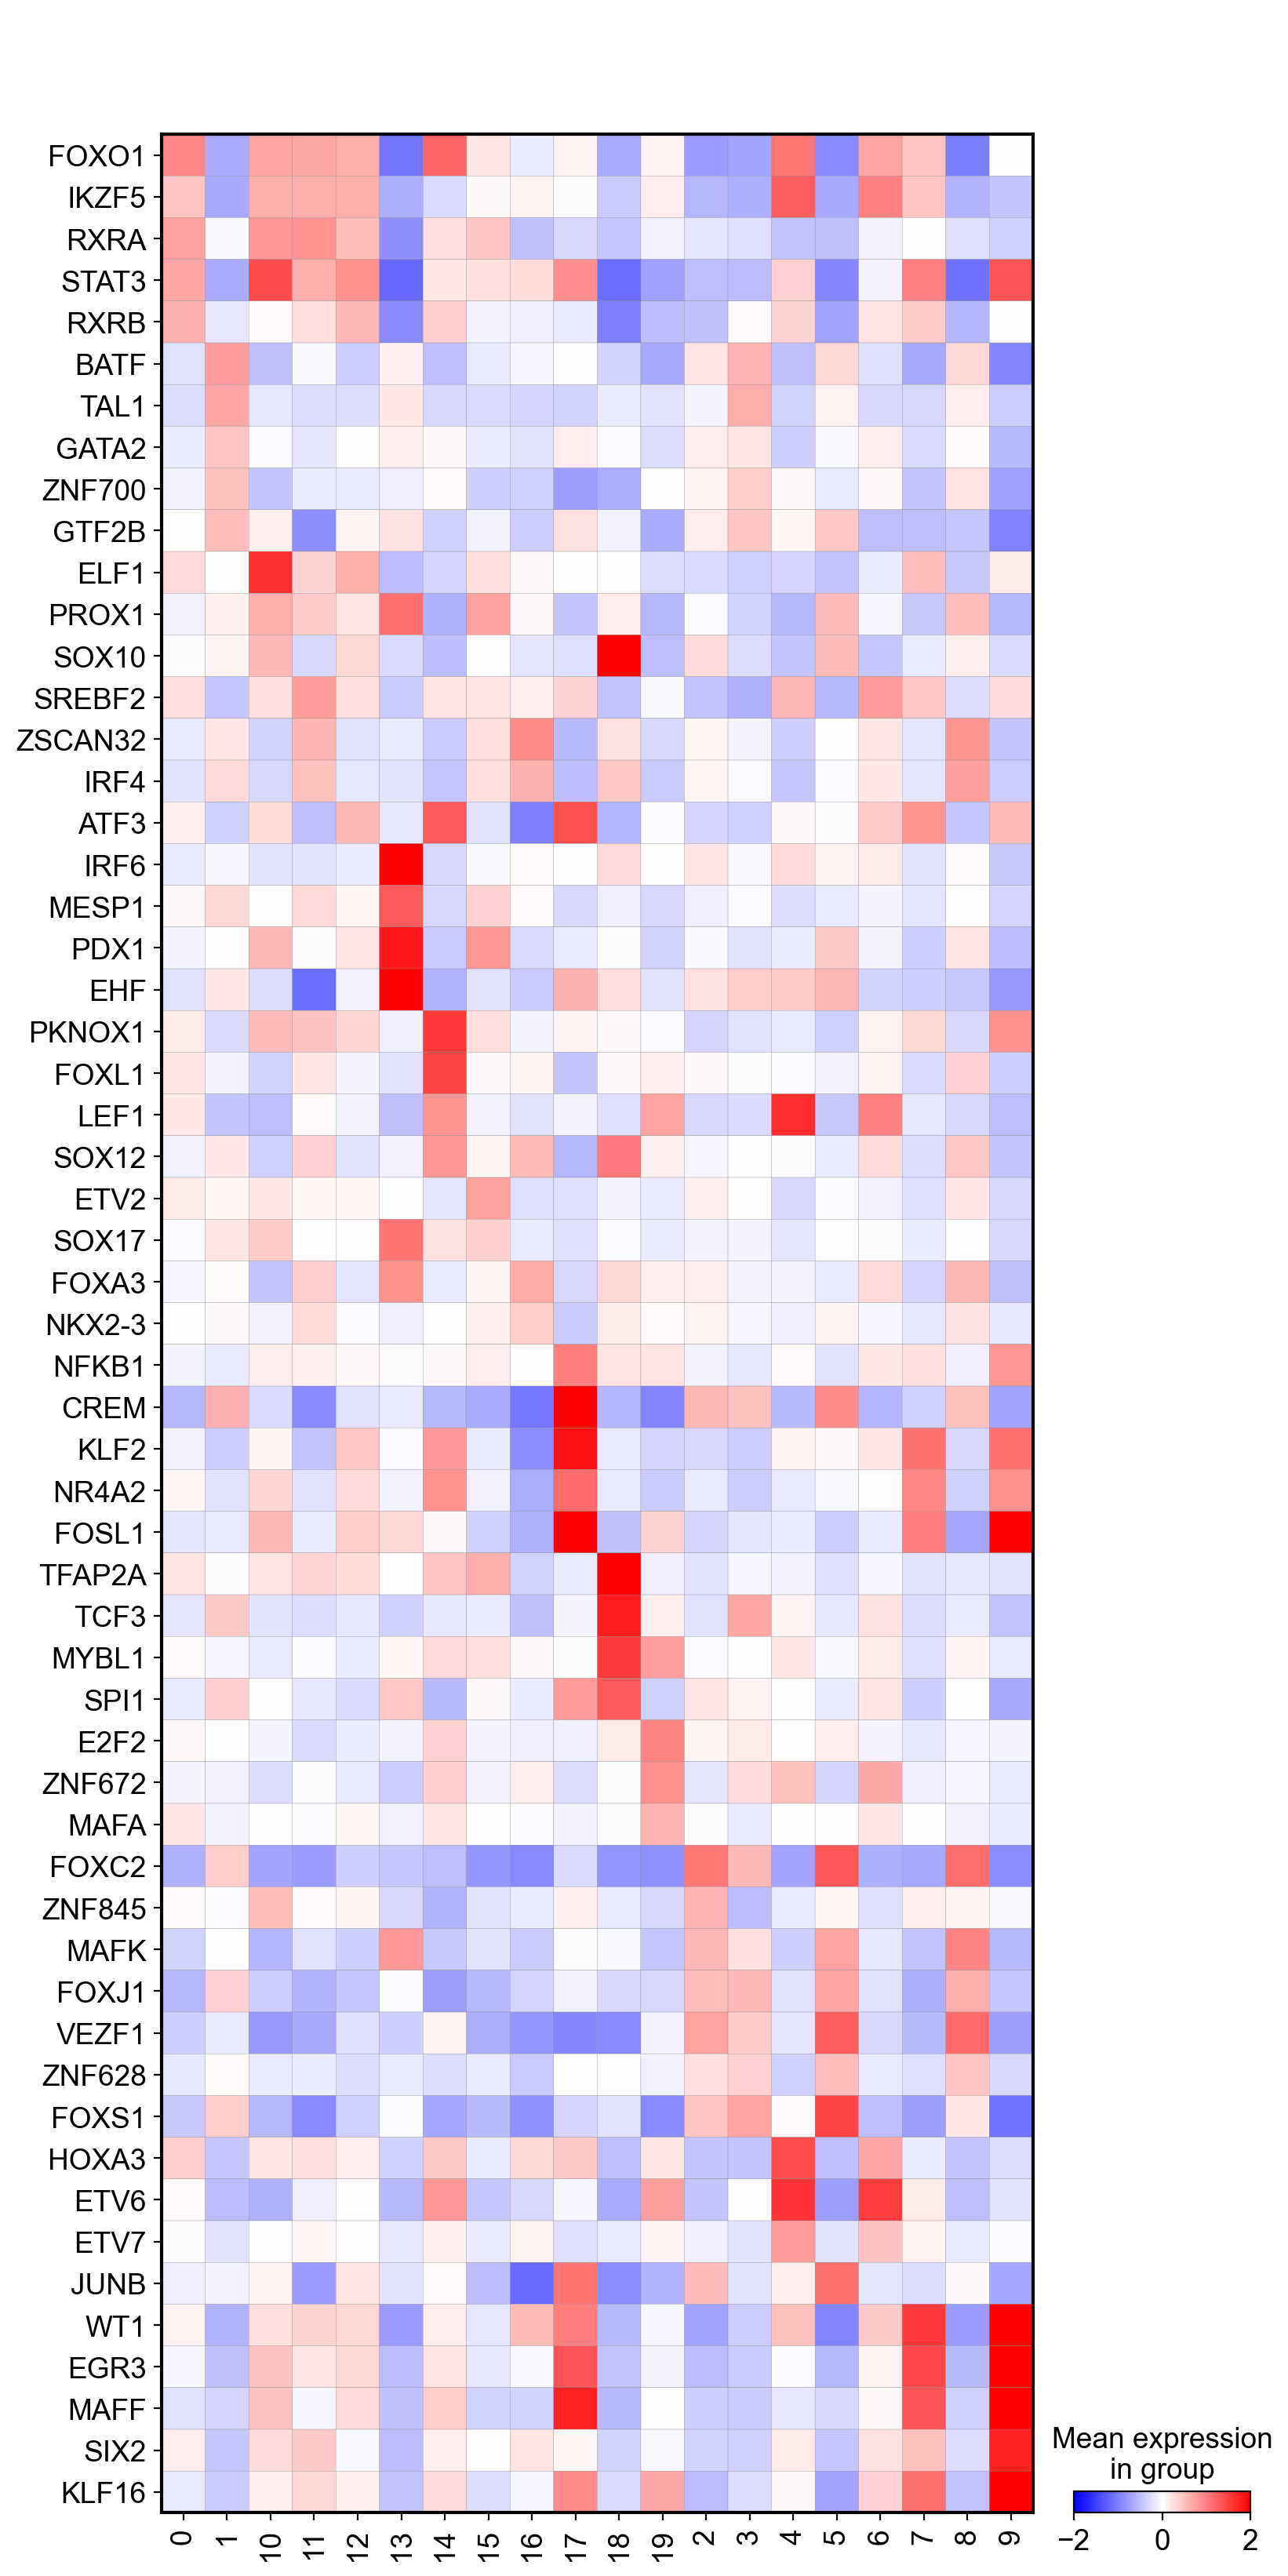

In [98]:
aucell_adata
aucell_adata.layers['scaled'] = auc_mtx_Z.values
sc.settings.set_figure_params(dpi=100,dpi_save=300,frameon=True,facecolor='white',fontsize=16,vector_friendly=True,figsize=(5,5))
sc.pl.matrixplot(aucell_adata,topreg_unique,groupby=resolution, cmap='bwr',layer='scaled',vmin=-2,vmax=2,swap_axes=True,save='top_n_tfs_auc_heatmap.pdf')

In [99]:
f_tfs = "/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/script/spatial_pipeline/bin/SCENIC/resources/hs_hgnc_curated_tfs.txt"  # human
# 找adata里每个cluster top5的差异TF做热图
TFs = open(f_tfs,'r').readlines()
TFs = [tf.strip() for tf in TFs]

In [100]:
adata_tfs = adata[:,adata.var_names.isin(TFs)].copy()
adata_tfs

AnnData object with n_obs × n_vars = 27063 × 1359
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'group', 'percent.mt', 'pANN_0.25_0.005_201', 'doublet_info', 'RNA_snn_res.0.4', 'seurat_clusters', 'RNA_snn_res.0.5', 'RNA_snn_res.0.8', 'RNA_snn_res.1.2', 'RNA_snn_res.1', 'celltype', 'pANN_0.25_0.18_1130', 'pANN_0.25_0.005_152', 'pANN_0.25_0.01_119', 'pANN_0.25_0.03_36', 'pANN_0.25_0.02_66', 'pANN_0.25_0.005_402', 'pANN_0.25_0.001_1065', 'pANN_0.25_0.005_193', 'pANN_0.25_0.001_1420', 'pANN_0.25_0.005_713', 'pANN_0.25_0.03_123', 'pANN_0.25_0.05_760', 'pANN_0.25_0.005_420', 'pANN_0.25_0.27_608', 'pANN_0.25_0.04_76', 'pANN_0.25_0.001_977', 'pANN_0.25_0.005_285', 'pANN_0.25_0.01_124', 'pANN_0.25_0.01_135', 'pANN_0.25_0.02_41', 'pANN_0.25_0.005_255', 'pANN_0.25_0.05_548', 'pANN_0.25_0.005_534', 'pANN_0.25_0.005_513', 'Patients', 'cellTypes', 'sample', 'tissue', 'cellTypes_new', 'cellTypes_filt', 'sampleType', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.9', 'RNA_snn_res.1.1', 'R

In [101]:
sys.path.insert(
    0,
    '/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/script/spatial_pipeline/lib'
)
from utils import getDefaultColors, removeBiasGenes, getDEG

sc.tl.rank_genes_groups(adata_tfs,
                        resolution,
                        method='wilcoxon',
                        use_raw=False,
                        tie_correct=True,
                        key_added='rank_genes_groups')
result = adata_tfs.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    group + '_' + key: result[key][group]
    for group in groups
    for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']
})
df.to_csv(f'DEG_TF_wilcoxon_{sample}.csv')



/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in true_divide
  scores[group_index, :] = (
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in true_divide
  scores[group_index, :] = (
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in true_divide
  scores[group_index, :] = (
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in true_divide
  scores[group_index, :] = (
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/scanpy/scanpy/tools/_rank_genes_groups.py:322: RuntimeWarning: invalid value encountered in true_divide
  scores[group_index, :] = (
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/scanp

In [102]:
adata_tfs.layers['scaled'] = sc.pp.scale(adata_tfs, copy=True).X
sc.settings.set_figure_params(dpi=100,dpi_save=300,frameon=True,facecolor='white',fontsize=16,vector_friendly=True,figsize=(5,5))
# sc.pl.rank_genes_groups_matrixplot(adata_tfs, n_genes=10,groupby=resolution, use_raw=False, cmap='bwr',  layer='scaled',vmin=-2,vmax=2,save='top_n_tfs_expr_heatmap.pdf')
# sc.pl.rank_genes_groups_dotplot(adata_tfs, n_genes=10,groupby=resolution, use_raw=False, cmap='bwr',  layer=None,save='top_n_tfs_expr_dotplot.pdf')

/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/scanpy/scanpy/plotting/_utils.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
meta NOT subset; don't know how to subset; dropped
/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/miniconda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


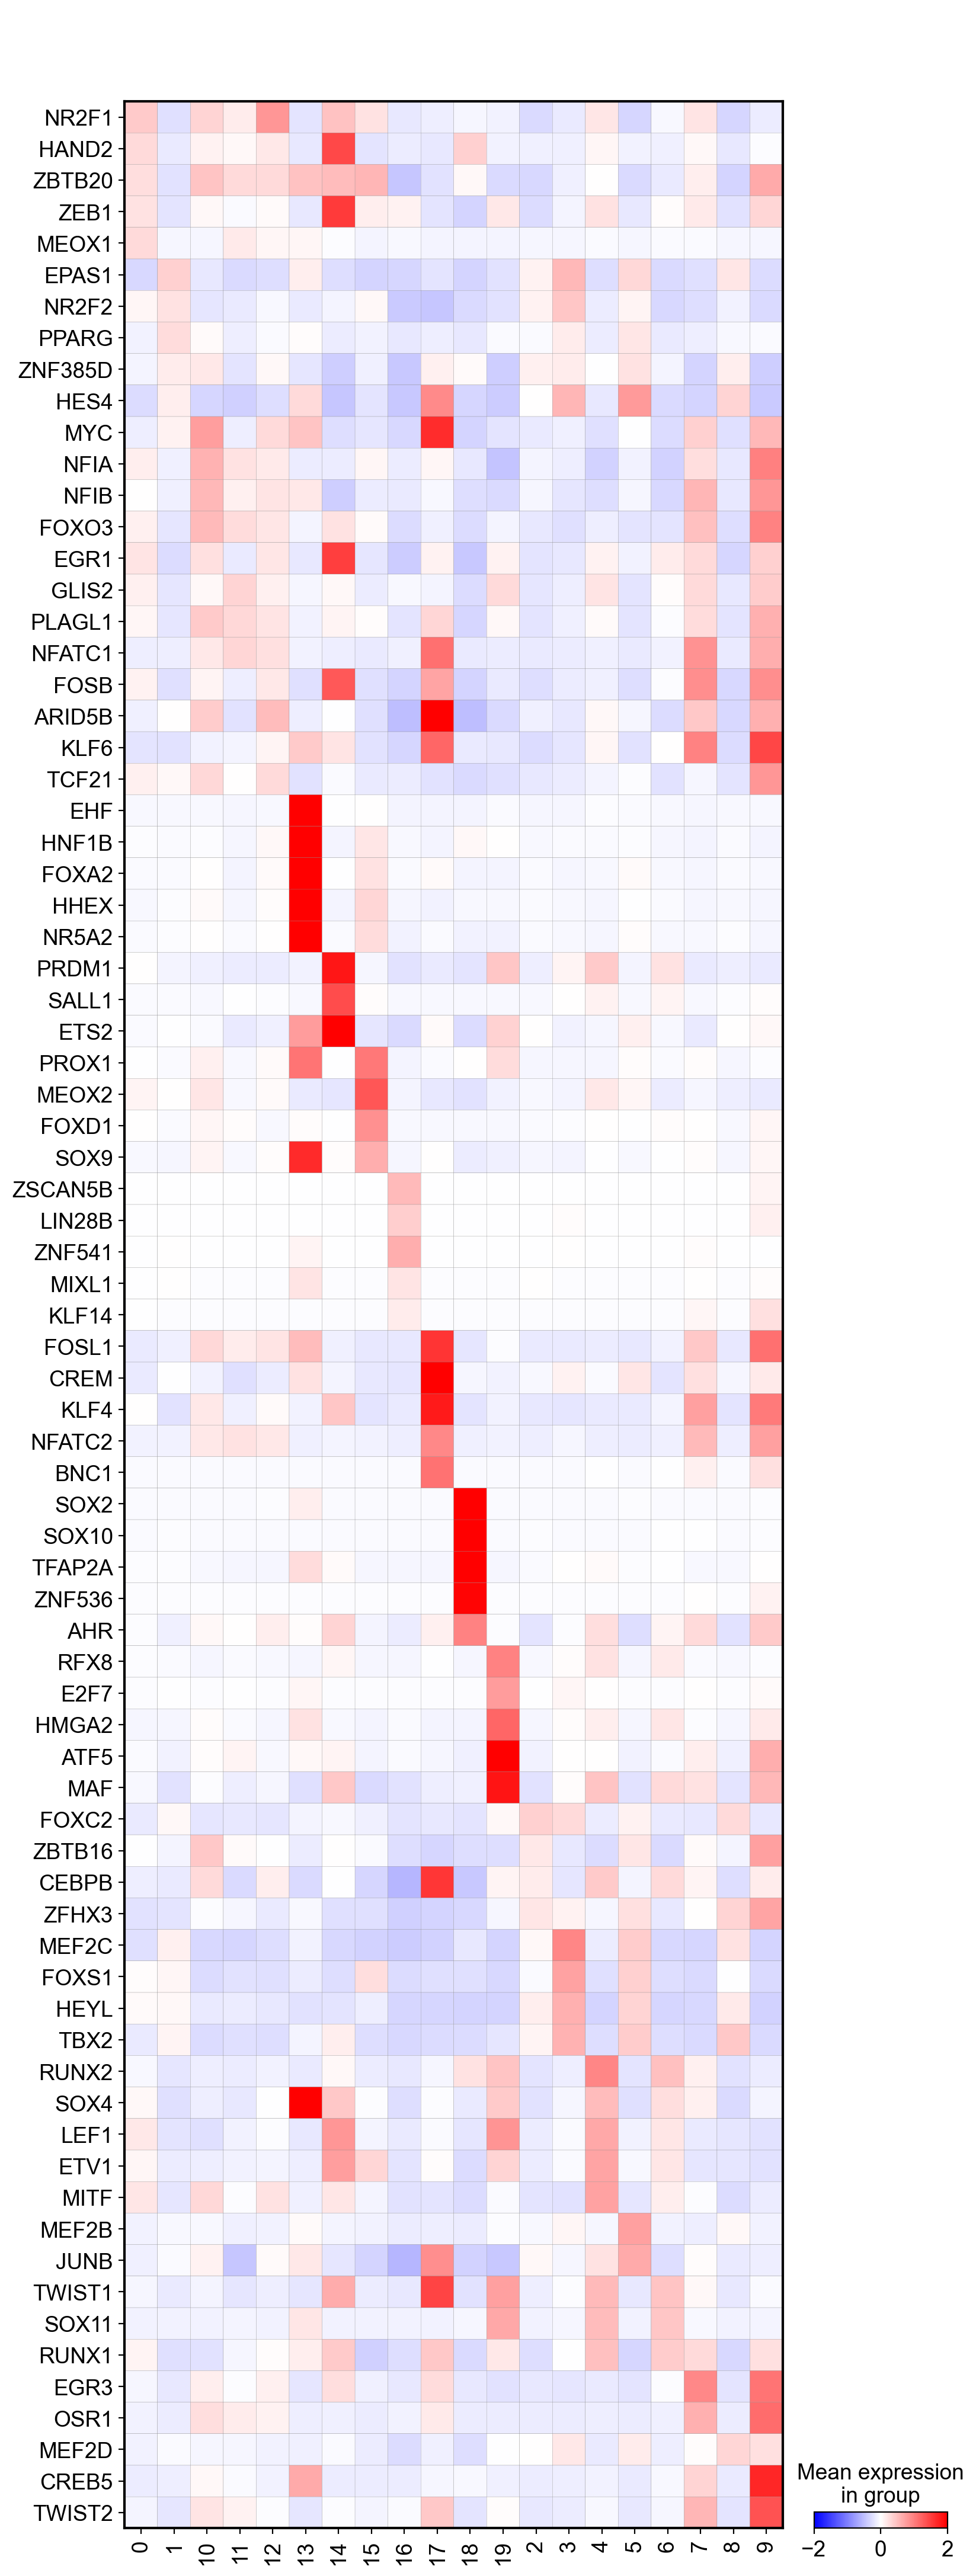

In [103]:
result = adata_tfs.uns['rank_genes_groups']
groups = result['names'].dtype.names
top_genes_per_group = pd.DataFrame(
    {group: result['names'][group][:5] for group in groups}
)
top_genes_list = []
for group in groups:
    top_genes_list += top_genes_per_group[group].tolist()
top_genes_list_unique = []
for gene in top_genes_list:
    if gene not in top_genes_list_unique:
        top_genes_list_unique.append(gene )
sc.settings.set_figure_params(dpi=100,dpi_save=300,frameon=True,facecolor='white',fontsize=16,vector_friendly=True,figsize=(5,5))
sc.pl.matrixplot(adata_tfs,top_genes_list_unique,groupby=resolution, cmap='bwr',layer='scaled',swap_axes=True,vmin=-2,vmax=2,save='top_n_tfs_expr_heatmap.pdf')


meta NOT subset; don't know how to subset; dropped


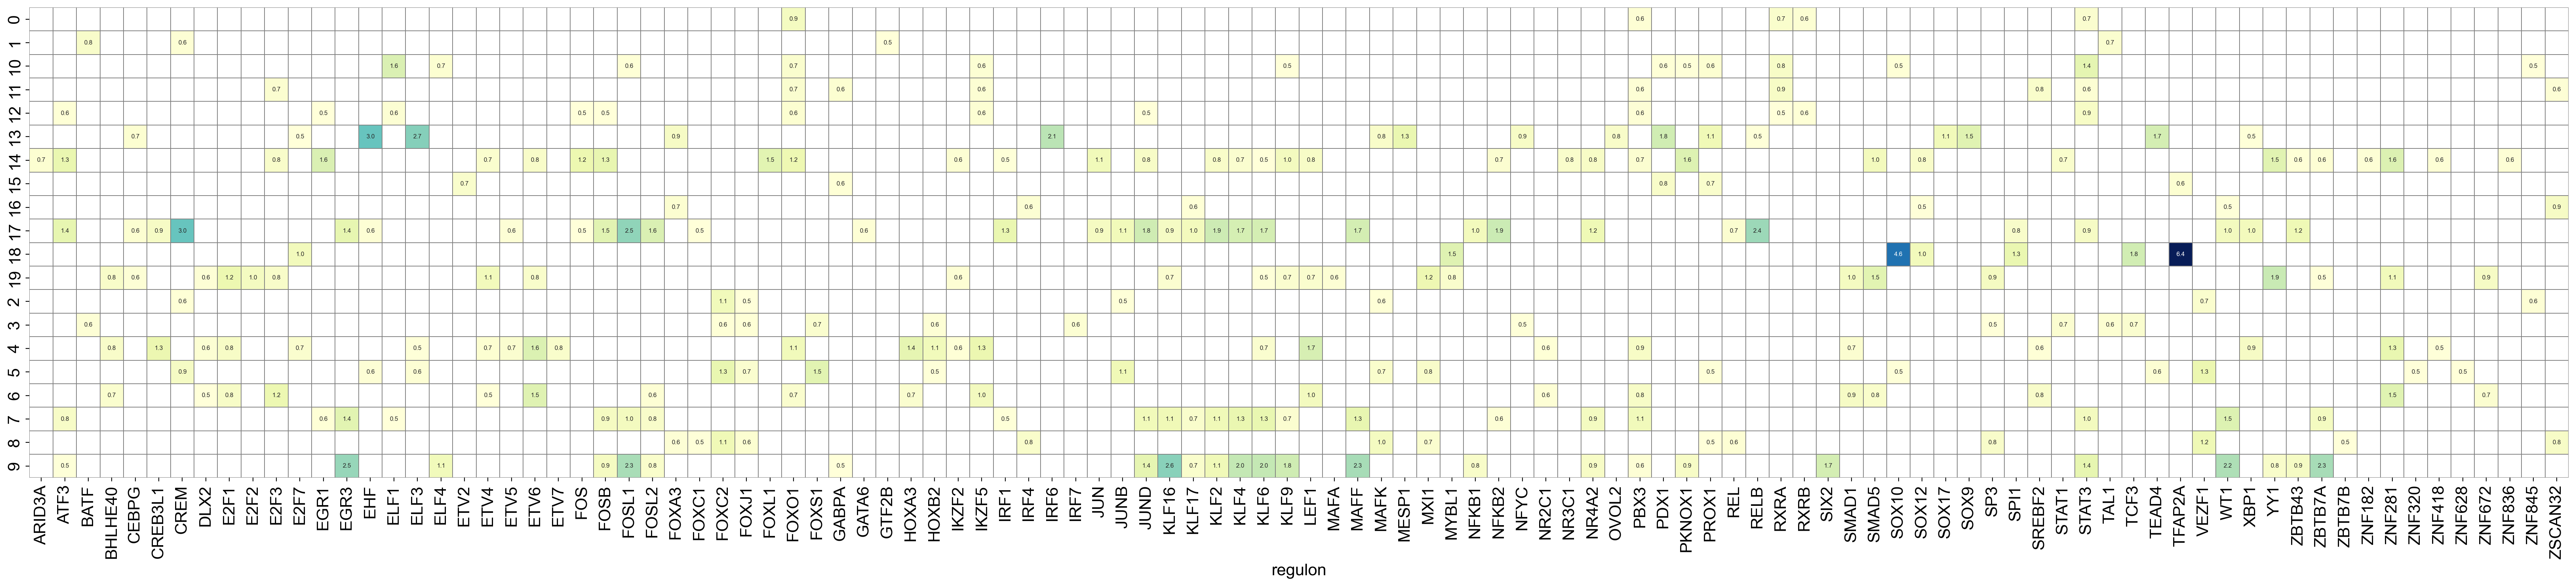

In [106]:
df_obs = adata.obs
signature_column_names = list(df_obs.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
df_scores = df_obs[signature_column_names + [resolution]]
df_results = ((df_scores.groupby(by=resolution).mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
df_results[(df_results.Z >= 0.5)].sort_values('Z', ascending=False).head()
df_heatmap = pd.pivot_table(data=df_results[df_results.Z >= 0.5].sort_values('Z', ascending=False),
                           index=resolution, columns='regulon', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(35, 22))
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6})
ax1.set_ylabel('')
fig.savefig('CELL_TYPE_SPECIFIC_REGULATORS.pdf', bbox_inches='tight', dpi=300)

In [11]:
adjacencies = pd.read_csv("adj.tsv", index_col=False,sep='\t')

In [13]:
from pyscenic.utils import modules_from_adjacencies
from pyscenic.prune import prune2df, df2regulons
modules = list(modules_from_adjacencies(adjacencies, exp_mtx))


2023-10-17 14:44:22,962 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-10-17 14:44:24,261 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2023-10-17 14:45:27,932 - pyscenic.utils - INFO - Creating modules.


In [ ]:
tf_mods

In [15]:
tf = 'ELF1'
tf_mods = [x for x in modules if x.transcription_factor == tf]

for i, mod in enumerate(tf_mods):
    print(f'{tf} module {str(i)}: {len(mod.genes)} genes')
# print(f'{tf} regulon: {len(regulons[tf+"_(+)"])} genes')

ELF1 module 0: 5452 genes
ELF1 module 1: 3132 genes
ELF1 module 2: 51 genes
ELF1 module 3: 129 genes
ELF1 module 4: 451 genes
ELF1 module 5: 3874 genes


In [21]:
for i, mod in enumerate(tf_mods):
    with open(tf + '_module_' + str(i) + '.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)

with open(tf + '_regulon.txt', 'w') as f:
    for item in regulons:
        if item.name == tf:
            sorted_genes = sorted(item.gene2weight.keys(), key=lambda k: item.gene2weight[k], reverse=True)
            for gene in sorted_genes:
                if gene != tf:
                    f.write(f"{gene}\n")

In [20]:
import networkx as nx
def export_regulons(regulons, fname: str) -> None:
    graph = nx.DiGraph()
    for regulon in regulons:
        src_name = regulon.transcription_factor
        graph.add_node(src_name, group="TF")
        edge_type = "activating" if "activating" in regulon.context else "inhibiting"
        node_type = "Gene"
        for dst_name, edge_strength in regulon.gene2weight.items():
            if dst_name == src_name:
                continue
            graph.add_node(dst_name, group=node_type)
            graph.add_edge(
                src_name,
                dst_name,
                weight=edge_strength,
                interaction=edge_type
            )
    nx.readwrite.write_graphml(graph, fname)

In [19]:
def plot_networkx(G, pos):
    nx.draw_networkx_nodes(G, pos, node_color=nx.get_node_attributes(G,'color').values(),
                           node_size=list(nx.get_node_attributes(G,'size').values()),
                           node_shape = 'D')
    nx.draw_networkx_edges(G, pos, edge_color = nx.get_edge_attributes(G,'color').values(),
                          width = list(nx.get_edge_attributes(G,'width').values()))
    fontsize_d = {y:x['size'] for x,y in zip(list(nx.get_node_attributes(G,'font').values()),list(nx.get_node_attributes(G,'label').values())) if x['size'] != 0.0}
    fontcolor_d = {y:x['color'] for x,y in zip(list(nx.get_node_attributes(G,'font').values()),list(nx.get_node_attributes(G,'label').values())) if x['size'] != 0.0}
    for node, (x, y) in pos.items():
        if node in fontsize_d.keys():
            plt.text(x, y, node, fontsize=fontsize_d[node], color=fontcolor_d[node],  ha='center', va='center')
    ax = plt.gca()
    ax.margins(0.11)
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    
import json
def export_to_cytoscape(G, pos, out_file: str, pos_scaling_factor:int = 200, size_scaling_factor:int=1):
    """
    A function to export to cytoscape    
    Parameters
    ---------
    G: Graph
        A networkx graph.
    Pos: coordinates of graph nodes
        generated by running create_nx_graph.
    out_file: str
        Path to wich to save the export.
    pos_scaling_factor: int, optional
        Factor by which to scale the graph node coordinates.
    size_scaling_factor: int, optional
        Factor by which tos cale the graph node sizes.
    """
    cy = nx.cytoscape_data(G)
    for n in cy["elements"]["nodes"]:
        for k, v in n.items():
            v["label"] = v.pop("value")
    for n, p in zip(cy["elements"]["nodes"], pos.values()):
        if not np.isnan(p[0]) and not np.isnan(p[1]):
            n["position"] = {"x": int(p[0] * pos_scaling_factor), "y": int(p[1] * pos_scaling_factor)}
        else: 
            n["position"] = {"x": 0, "y": 0}
    # for n in cy["elements"]["nodes"]:
    #     n['data']['font_size'] = int(n['data']['font_size'])
    #     n['data']['size'] = n['data']['size']*size_scaling_factor
    #     n['data']['shape'] = n['data']['shape'].capitalize()
    json_string = json.dumps(cy, indent = 2)
    with open(out_file, 'w') as outfile:
        outfile.write(json_string) 

In [113]:
export_regulons(regulons, 'regulons.graphml')

In [22]:
select_regulons = ['ELF1']
regulons_list = []
for regulon in regulons:
    if regulon.name in select_regulons:
        regulons_list.append(regulon)
export_regulons(regulons_list, 'select_regulons.graphml')

/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/software/miniconda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


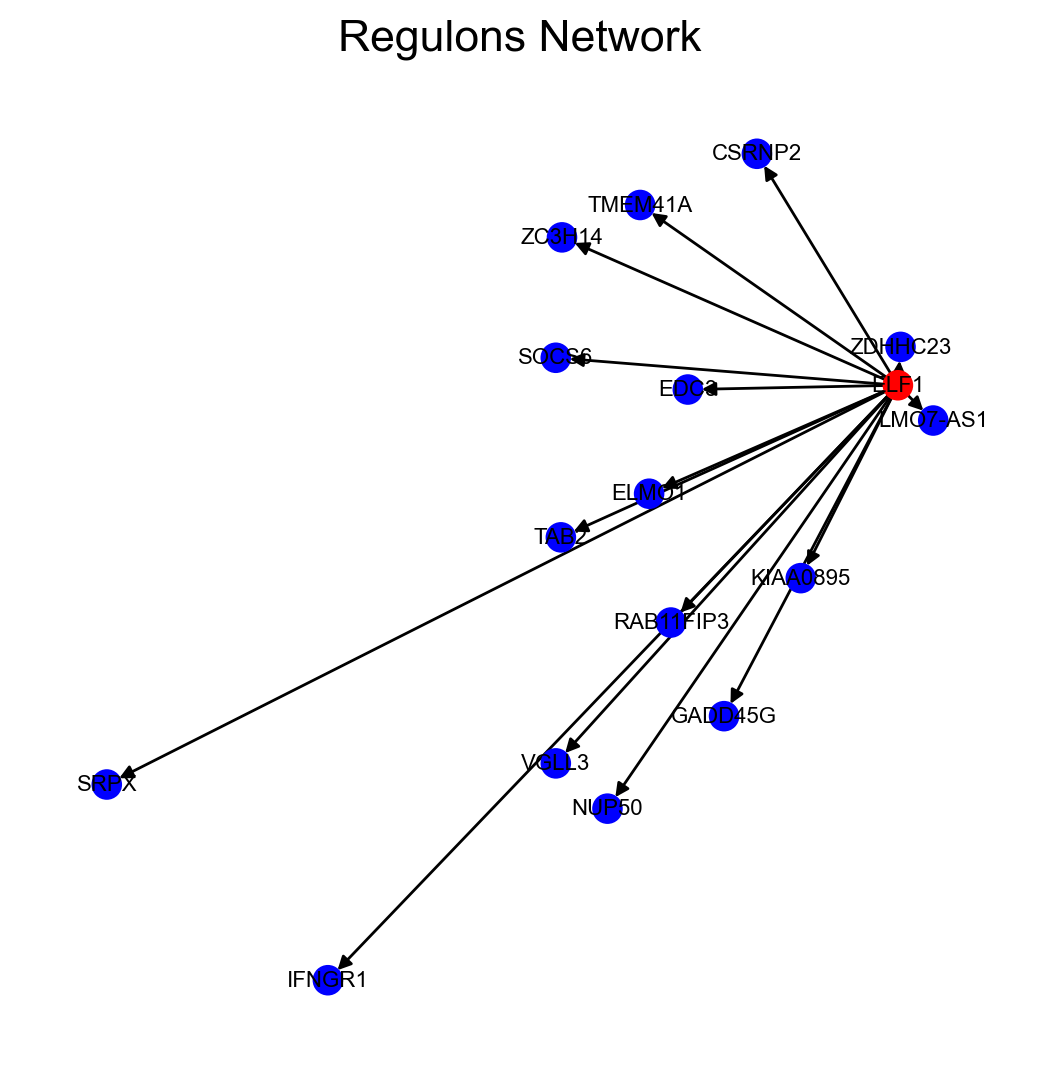

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# 读取 graphml 文件
G = nx.read_graphml("select_regulons.graphml")

# 创建节点颜色映射
node_colors = {
    node: 'red' if G.nodes[node]['group'] == 'TF' else 'blue'
    for node in G.nodes
}
pos = nx.kamada_kawai_layout(G)

# # 绘制网络图
nx.draw(G, pos, with_labels=True, node_size=100, node_color=[node_colors[node] for node in G.nodes],
        font_size=8, font_color='black', font_weight='bold')

plt.title("Regulons Network")
plt.show()

In [25]:
export_to_cytoscape(G, pos, out_file = 'ELF1_TF_cytoscape.json')

In [ ]:
import os, sys
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.insert(
    0,
    '/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/script/spatial_pipeline/lib/utils'
)
from spatial.utils import getDefaultColors, removeBiasGenes, getDEG
sc.settings.set_figure_params(dpi=100,dpi_save=300,frameon=False,facecolor='white',fontsize=16,vector_friendly=True,figsize=(4,4))
sc._settings.ScanpyConfig(figdir='./',n_jobs=30)
# Set maximum number of jobs
sc.settings.njobs = 30
sc.settings.set_figure_params(dpi=100,dpi_save=300,frameon=False,facecolor='white',fontsize=16,vector_friendly=True,figsize=(5,5))


In [ ]:
wdir = f"/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/5.8_scRNA_CAF_TF/"
os.system(f'mkdir -p {wdir}')
os.chdir(wdir)

In [ ]:
adata = sc.read('/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/5.7_CAF_scRNA_monocle2/CAF_recluster.h5ad')

In [ ]:
adata

In [ ]:
aucell_adata = sc.read('/jdfsbjcas1/ST_BJ/P21H28400N0232/gongchanghao/project/PDAC/spatial/cellbin_v3/5.8_scRNA_CAF_TF/anndata.h5ad')

In [ ]:
aucell_adata.obs

In [ ]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [ ]:
TFs = ['NRL','SOX4','ETS2','SHOX','PITX1','TCF21']
# TFs_str = ['Regulon(' + x + ')' for x in TFs]
# sc.pl.umap(aucell_adata, color=TFs_str,save='TFs_auc_umap.pdf')
sc.pl.umap(adata, color=TFs,use_raw=False,save='TFs_expr_umap.pdf')